# ISE Cryptography Week 2

These challenges are going to be much easier if you complete the exercises from the lecture first!
You should have working implementations of the Caesar cipher and One-Time Pad, and be comfortable working with bytes in Python before you start.

## TEA Block Cipher

Implement the Tiny Encryption Algorithm (TEA) block cipher. You can find the specification for TEA [here](https://en.wikipedia.org/wiki/Tiny_Encryption_Algorithm).

Remember, the reference implementation uses arrays of 32-bit unsigned integers. The block size is 64 bits, and the key is 128 bits long.

Think about how you can test your implementation. You should be able to encrypt and decrypt a message, and get the original message back.

**Hint:** You can use the `struct` module to convert between bytes and integers in Python really easily. This'll be useful for converting the key and message to the right format for TEA, depending on how you choose to implement it.

**Hint:** Python's integers have no max size. You can use `& 0xffffffff` to keep only the least significant 32 bits of an integer.

**Hint:** You've already got a reference implementation in C. You can use this to test your Python implementation and make sure it's working correctly.

```c
#include <stdint.h>

void encrypt (uint32_t v[2], const uint32_t k[4]) {
    uint32_t v0=v[0], v1=v[1], sum=0, i;           /* set up */
    uint32_t delta=0x9E3779B9;                     /* a key schedule constant */
    uint32_t k0=k[0], k1=k[1], k2=k[2], k3=k[3];   /* cache key */
    for (i=0; i<32; i++) {                         /* basic cycle start */
        sum += delta;
        v0 += ((v1<<4) + k0) ^ (v1 + sum) ^ ((v1>>5) + k1);
        v1 += ((v0<<4) + k2) ^ (v0 + sum) ^ ((v0>>5) + k3);
    }                                              /* end cycle */
    v[0]=v0; v[1]=v1;
}

void decrypt (uint32_t v[2], const uint32_t k[4]) {
    uint32_t v0=v[0], v1=v[1], sum=0xC6EF3720, i;  /* set up; sum is (delta << 5) & 0xFFFFFFFF */
    uint32_t delta=0x9E3779B9;                     /* a key schedule constant */
    uint32_t k0=k[0], k1=k[1], k2=k[2], k3=k[3];   /* cache key */
    for (i=0; i<32; i++) {                         /* basic cycle start */
        v1 -= ((v0<<4) + k2) ^ (v0 + sum) ^ ((v0>>5) + k3);
        v0 -= ((v1<<4) + k0) ^ (v1 + sum) ^ ((v1>>5) + k1);
        sum -= delta;
    }                                              /* end cycle */
    v[0]=v0; v[1]=v1;
}
```

In [6]:
import struct 

def encrypt(v, k):
    v0, v1 = struct.unpack('!2L', v)  # Unpack the 64-bit plaintext block into two 32-bit variables
    k0, k1, k2, k3 = struct.unpack('!4L', k)  # Unpack the 128-bit key into four 32-bit variables
    delta = 0x9e3779b9  # Key schedule constant
    sum = 0  # Initialize sum

    for i in range(32):  # 32 rounds
        sum = (sum + delta) & 0xffffffff  # Update sum using modular addition
        v0 += ((v1 << 4) + k0) ^ (v1 + sum) ^ ((v1 >> 5) + k1)  # Update v0
        v0 &= 0xffffffff  # Ensure v0 stays within 32 bits
        v1 += ((v0 << 4) + k2) ^ (v0 + sum) ^ ((v0 >> 5) + k3)  # Update v1
        v1 &= 0xffffffff  # Ensure v1 stays within 32 bits

    return struct.pack('!2L', v0, v1)  # Pack the two 32-bit variables back into a 64-bit block and return


def decrypt(v, k):
    v0, v1 = struct.unpack('!2L', v)  # Unpack the 64-bit ciphertext block into two 32-bit variables
    k0, k1, k2, k3 = struct.unpack('!4L', k)  # Unpack the 128-bit key into four 32-bit variables
    delta = 0x9e3779b9  # Key schedule constant
    sum = (delta * 32) & 0xffffffff  # Initialize sum with the last value used in encryption

    for i in range(32):  # 32 rounds
        v1 += ((v0 << 4) + k2) ^ (v0 + sum) ^ ((v0 >> 5) + k3)  # Update v1
        v1 &= 0xffffffff  # Ensure v1 stays within 32 bits
        v0 += ((v1 << 4) + k0) ^ (v1 + sum) ^ ((v1 >> 5) + k1)  # Update v0
        v0 &= 0xffffffff  # Ensure v0 stays within 32 bits
        sum = (sum - delta) & 0xffffffff  # Update sum in reverse order

    return struct.pack('!2L', v0, v1)  # Pack the two 32-bit variables back into a 64-bit block and return



## Electronic Codebook (ECB) Mode

Implement the Electronic Codebook (ECB) mode of operation for the TEA block cipher. Divide the plaintext into 64-bit blocks, and encrypt each block separately. Concatenate the ciphertext blocks to form the final ciphertext. Remember to pad the last block if necessary!

You'll need to implement encryption and decryption functions for ECB mode. The encryption function should take a plaintext and a key, and return the ciphertext. The decryption function should take a ciphertext and a key, and return the plaintext.

Think about whether or not you can parallelize the encryption and/or decryption functions. How many blocks can you encrypt or decrypt at the same time? Is random read access feasible, or do you need to read the blocks sequentially?

In [7]:
def pad(text):
    while len(text) % 8 != 0:
        text += b'\0'
    return text

def encrypt_ecb(plaintext, key):
    plaintext = pad(plaintext)
    ciphertext = b''

    for i in range(0, len(plaintext), 8):
        block = plaintext[i:i+8]
        ciphertext += encrypt(block, key)
    return ciphertext

def decrypt_ecb(ciphertext, key):
    plaintext = b''

    for i in range(0, len(ciphertext), 8):
        block = ciphertext[i:i+8]
        plaintext += decrypt(block, key)
    return plaintext

"""
- each block is encrypted or decrypted independently of the other blocks
- you can encrypt or decrypt each block in parallel, as many as you want
- random read access is not feasible, you need to read the blocks sequentially in order 
to maintain 
"""


'\n- each block is encrypted or decrypted independently of the other blocks\n- you can encrypt or decrypt each block in parallel, as many as you want\n- random read access is not feasible, you need to read the blocks sequentially in order \nto maintain \n'

## The Penguin of Doom

Open the file `assets/tux.png` and convert it to a bitmap image before displaying it. You can use the Python Imaging Library (PIL) to do this. You should see an image of the Linux mascot, Tux the penguin.

Encrypt the image using ECB mode with the TEA block cipher. Display the encrypted image. Decrypt the image and display it again. You should see the original image of Tux.

What do you notice about the encrypted image? How does it compare to the original image?

For comparison, try encrypting the image data using your one-time pad implementation. How does the encrypted image compare to the TEA-ECB-encrypted image?

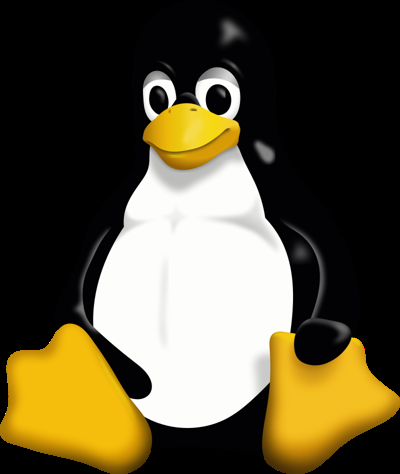

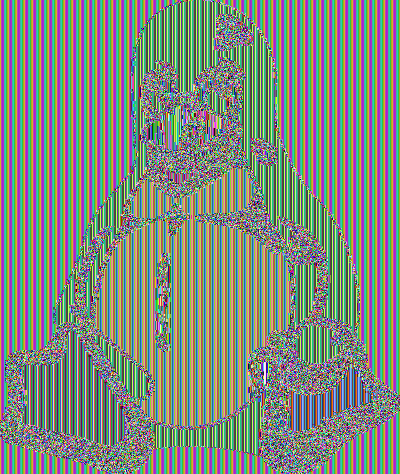

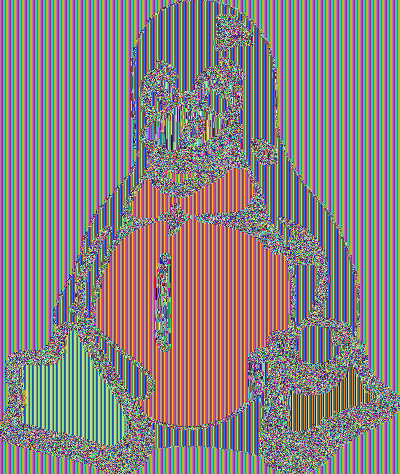

In [8]:
from typing import Tuple
from PIL import Image


def image_to_bytes(image: Image) -> bytes:
    return bytes(image.tobytes("raw", "RGB"))


def bytes_to_image(data: bytes, size: Tuple[int, int]) -> bytes:
    return Image.frombytes("RGB", size, data)


# Read the image and convert it to a bitmap of bytes
tux_image = Image.open("../assets/Tux.png")

# Resize the image
tux_image = tux_image.resize((tux_image.size[0] // 2, tux_image.size[1] // 2))

# Convert the resized image to bytes
tux_image_bytes = image_to_bytes(tux_image)

# Encrypt, decrypt, and display as before

# Restore the image from the raw data like this
display(bytes_to_image(tux_image_bytes, tux_image.size))

# TODO: Your code here!
# Define a key for encryption and decryption
# Define a key for encryption and decryption
key = bytes.fromhex('0123456789abcdef0123456789abcdef')  # 16 bytes = 128 bits

# Encrypt the image
encrypted_image_bytes = encrypt_ecb(tux_image_bytes, key)

# Convert the encrypted bytes back to an image and display it
encrypted_image = bytes_to_image(encrypted_image_bytes, tux_image.size)
display(encrypted_image)

# Decrypt the image
decrypted_image_bytes = decrypt_ecb(encrypted_image_bytes, key)

# Convert the decrypted bytes back to an image and display it
decrypted_image = bytes_to_image(decrypted_image_bytes, tux_image.size)
display(decrypted_image)



## The Penguin of Doom, Part 2

So ECB mode isn't very secure. Implement the Cipher Block Chaining (CBC) mode of operation for the TEA block cipher, detailed [here](https://en.wikipedia.org/wiki/Block_cipher_mode_of_operation#Cipher_block_chaining_(CBC)). You'll need to generate an Initialization Vector (IV) to use with the first block. Remember to XOR the IV with the first plaintext block before encrypting it. Do some research on how to generate a secure IV.

Encrypt the image using CBC mode with the TEA block cipher. Display the encrypted image. Decrypt the image and display it again. You should see the original image of Tux. How does the CBC-encrypted image compare to the ECB-encrypted image?

What happens if you get the IV wrong when decrypting the image? How does the decrypted image compare to the original image? Why is this?

Now think about concurrency again. Can you parallelize the encryption and/or decryption functions? How many blocks can you encrypt or decrypt at the same time? Is random read access feasible, or do you need to read the blocks sequentially?

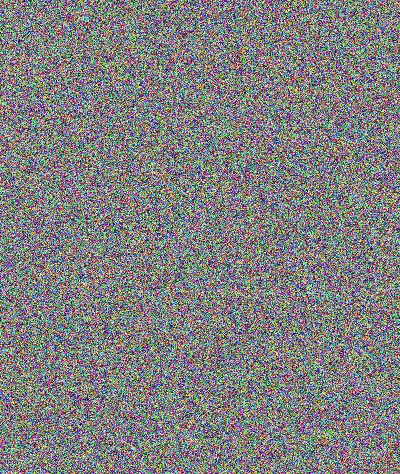

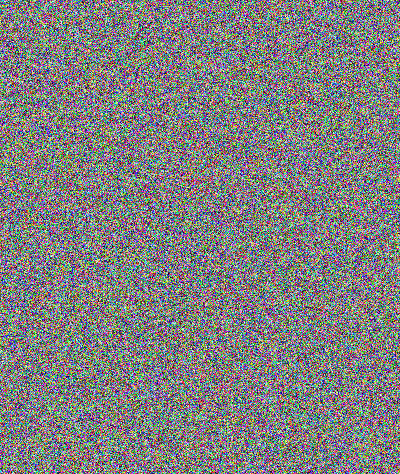

In [9]:
import os
import struct

def xor_bytes(a, b):
    return bytes(x ^ y for x, y in zip(a, b))

def encrypt_cbc(plaintext, key, iv):
    ciphertext = b''
    previous_block = iv

    for i in range(0, len(plaintext), 8):
        block = plaintext[i:i+8]
        block = xor_bytes(block, previous_block)
        encrypted_block = encrypt(block, key)   
        ciphertext += encrypted_block
        previous_block = encrypted_block
    return ciphertext

def decrypt_cbc(ciphertext, key, iv):
    plaintext = b''
    previous_block = iv

    for i in range(0, len(ciphertext), 8):
        block = ciphertext[i:i+8]
        decrypted_block = decrypt(block, key)
        decrypted_block = xor_bytes(decrypted_block, previous_block)
        plaintext += decrypted_block
        previous_block = block
    return plaintext


iv = os.urandom(8)



encrypted_image_bytes = encrypt_cbc(tux_image_bytes, key, iv)
encrypted_image = bytes_to_image(encrypted_image_bytes, tux_image.size)
display(encrypted_image)

decrypted_image_bytes = decrypt_cbc(encrypted_image_bytes, key, iv)
decrypted_image = bytes_to_image(decrypted_image_bytes, tux_image.size)
display(decrypted_image)

## The Penguin of Doom, Part 3

Research and implement each of the modes of operation below for the TEA block cipher. You should have implemented ECB and CBC modes already!
- Cipher Feedback (CFB)
- Output Feedback (OFB)
- Propagating Cipher Block Chaining (PCBC)

Encrypt the image using your chosen mode of operation with the TEA block cipher. Display the encrypted image. Decrypt the image and display it again. You should see the original image of Tux. How does the encrypted image compare to the ECB- and CBC-encrypted images?

What are the advantages and disadvantages of the mode you chose compared to ECB and CBC?

Pick your favorite mode of operation from this task. Put together a (very) short presentation on the mode, 5 minutes tops, you might be asked to present it to the class next week! This could be a few short slides, or just a few bullet points and some code snippets. The core idea here it to make sure you understand the material well enough to explain it to someone else!

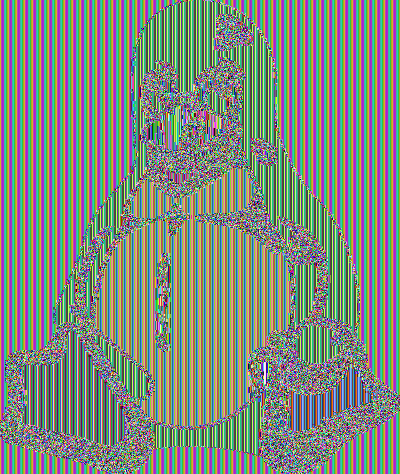

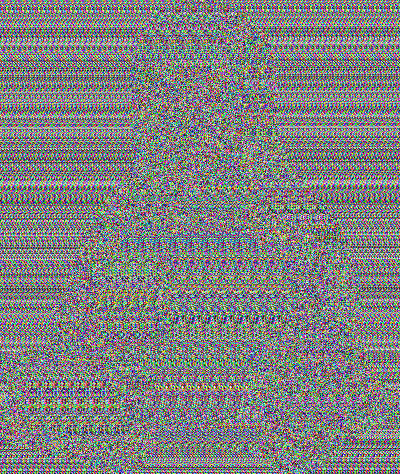

In [23]:
def pad(text):
    padding_length = 8 - (len(text) % 8)
    text += bytes([0]) * padding_length  # pad with null bytes
    return text

def unpad(text):
    padding_length = text[-1]  # get the padding length from the last block
    if padding_length > 0 and padding_length <= 8:  # check that the padding length is valid
        return text[:-padding_length]  # remove the padding
    return text

def encrypt_pcbc(plaintext, key, iv):
    plaintext = pad(plaintext)  # Pad the plaintext if necessary
    ciphertext = b''  # Initialize an empty ciphertext
    prev_plaintext_block = iv
    prev_ciphertext_block = iv

    for i in range(0, len(plaintext), 8):  # Iterate over plaintext in blocks of 8 bytes
        block = plaintext[i:i+8]  # Get the current plaintext block
        ciphertext_block = encrypt(block, key)  # Encrypt the block and append it to the ciphertext
        ciphertext += ciphertext_block
        prev_plaintext_block = block
        prev_ciphertext_block = ciphertext_block
    return ciphertext

def decrypt_pcbc(ciphertext, key, iv):
    plaintext = b''  # Initialize an empty plaintext
    prev_plaintext_block = iv
    prev_ciphertext_block = iv

    for i in range(0, len(ciphertext), 8):  # Iterate over ciphertext in blocks of 8 bytes
        block = ciphertext[i:i+8]  # Get the current ciphertext block
        decrypted_block = decrypt(block, key)  # Decrypt the block and append it to the plaintext
        plaintext_block = bytes([a ^ b ^ c for a, b, c in zip(decrypted_block, prev_ciphertext_block, prev_plaintext_block)])
        plaintext += plaintext_block
        prev_plaintext_block = plaintext_block
        prev_ciphertext_block = block
    return unpad(plaintext)


iv = os.urandom(8)

encrypted_image_bytes = encrypt_pcbc(tux_image_bytes, key, iv)
encrypted_image = bytes_to_image(encrypted_image_bytes, tux_image.size)
display(encrypted_image)

decrypted_image_bytes = decrypt_pcbc(encrypted_image_bytes, key, iv)
decrypted_image = bytes_to_image(decrypted_image_bytes, tux_image.size)
display(decrypted_image)


## Vigenère Challenge 1

The following ciphertext was produced by a Vigenère Cipher. Only the characters A-Z were encrypted; other characters were discarded and spaces included only for display purposes Luckily, your adversary was lax and used a short key of 5 characters or less! See if you can crack the code.

For all of these challenges, letting me know the source of the text is sufficient!



> VROMW GYIHW NWPOB HUOBO RNTEW DTIWT YIVAA PRKRL NHNHJ PYIJS NRCCB YWTRR JNPIJ NQIJS LYWAS JNCGI MMNRW EEWQI FWRSG IASJI AESMW EJSVE AARTU EWAVV XFQIL IQIMF NWQIB RQIFF AOGLN RVRUA JQAHH VBTZI AEYCU OBOND GLNGR RCLRQ JNOYC HVWOR VIWDZ VMAEG HSBSW DEIFT UIJTG IWTVS WOSXQ EESXM OCQIF JRNRX JLYTN RFSWH NRMSB QNFRE CUEIB NBFUE ZMNNN RMTUI AECSA TJLRC UAJSV RPEAI AAYGR RPYUA GMXNJ MCHVR OIIIV IAYCE FEOTR VQIFI WTEEW CRSOH VWQAI MWGGI WTUSD SNRMA LIJRG LNGRR CLRQN NCVXN BYWCR HQIZX XBREO IAIOI TYAEB JJMNR CHRPJ DVIBD RGUAE IMHRA JSZYL HUEWD FSVEE XQAAQ ABVRP LRCJN QLNWN WUOBO NDNXF IGLPR RECAQ QRRNX ROAJX RNFXU GLJLS XQERZ NNVRP TVPUH VWVAA RNRFK JVREM IFKDS GAQIP LCUER NDGLN TVHNO SLRSC SYUYE AIGCO OELNW NWMIF GXVRV NDGSK ECVXU QXXBR EKOII QIFGX MCEWY NRMAO SEEOI RNTTU ENWND NRMNB XJLYL RSYEA GRIBT NXNIA HNROC BHVVN CBYUD FEEEU MVFES VHNZR NTEVO FXOOE FRDQM WGQMB ATVNE NFUEP SDNGI WAAGN AAHKE VRPUA AXRGL HTBFN CBQYA EIMWV XQHVW ORVIW D




In [25]:
from collections import Counter
from itertools import cycle

# English letter frequency
frequency = 'ETAOINSHRDLCUMWFGYPBVKJXQZ'

def vigenere_decrypt(ciphertext, key):
    def shift(c, k):  # Shift character c by k positions
        return chr((ord(c) - ord('A') - k) % 26 + ord('A'))

    # Decrypt the ciphertext using the key
    plaintext = ''
    for i, c in enumerate(ciphertext):
        plaintext += shift(c, ord(key[i % len(key)]) - ord('A'))
    return plaintext
ciphertext = 'VROMW GYIHW NWPOB HUOBO RNTEW DTIWT YIVAA PRKRL NHNHJ PYIJS NRCCB YWTRR JNPIJ NQIJS LYWAS JNCGI MMNRW EEWQI FWRSG IASJI AESMW EJSVE AARTU EWAVV XFQIL IQIMF NWQIB RQIFF AOGLN RVRUA JQAHH VBTZI AEYCU OBOND GLNGR RCLRQ JNOYC HVWOR VIWDZ VMAEG HSBSW DEIFT UIJTG IWTVS WOSXQ EESXM OCQIF JRNRX JLYTN RFSWH NRMSB QNFRE CUEIB NBFUE ZMNNN RMTUI AECSA TJLRC UAJSV RPEAI AAYGR RPYUA GMXNJ MCHVR OIIIV IAYCE FEOTR VQIFI WTEEW CRSOH VWQAI MWGGI WTUSD SNRMA LIJRG LNGRR CLRQN NCVXN BYWCR HQIZX XBREO IAIOI TYAEB JJMNR CHRPJ DVIBD RGUAE IMHRA JSZYL HUEWD FSVEE XQAAQ ABVRP LRCJN QLNWN WUOBO NDNXF IGLPR RECAQ QRRNX ROAJX RNFXU GLJLS XQERZ NNVRP TVPUH VWVAA RNRFK JVREM IFKDS GAQIP LCUER NDGLN TVHNO SLRSC SYUYE AIGCO OELNW NWMIF GXVRV NDGSK ECVXU QXXBR EKOII QIFGX MCEWY NRMAO SEEOI RNTTU ENWND NRMNB XJLYL RSYEA GRIBT NXNIA HNROC BHVVN CBYUD FEEEU MVFES VHNZR NTEVO FXOOE FRDQM WGQMB ATVNE NFUEP SDNGI WAAGN AAHKE VRPUA AXRGL HTBFN CBQYA EIMWV XQHVW ORVIW D'
# Remove spaces from the ciphertext
ciphertext = ciphertext.replace(' ', '')

# Try keys of length 1 to 5
for key_length in range(1, 6):
    key = ''
    for i in range(key_length):
        # Get every key_length-th character
        seq = ciphertext[i::key_length]
        # Count the frequency of each character in seq
        freq = Counter(seq)
        # The key is the character that is most frequently mapped to 'E'
        key += max(frequency, key=lambda c: freq.get(chr((ord(c) - ord('E')) % 26 + ord('A')), 0))
    # Decrypt the ciphertext using the key
    plaintext = vigenere_decrypt(ciphertext, key)
    print(f'Key: {key}, Plaintext: {plaintext[:50]}')  # Print the first 50 characters of the plaintext

Key: V, Plaintext: AWTRBLDNMBSBUTGMZTGTWSYJBIYNBYDNAFFUWPWQSMSMOUDNOX...
Key: RM, Plaintext: EFXAFUHWQKWKYCKVDCKCABCSFRCWFHHWEOJDAYAZWVWVSDHWSG...
Key: RVV, Plaintext: EWTVBLHNMFSBYTGQZTKTWWYJFIYRBYHNAJFUAPWUSMWMOYDNSX...
Key: RIVM, Plaintext: EJTAFYDWQOSKYGGVDGGCAFYSFVYWFLDWESFDACWZWZSVSHDWSK...
Key: RVMVM, Plaintext: EWCRKPDWMKWBDTPQZCGCASHJKMYWBHHNJFOYWYWZWMBMXYDWOG...


## Vigenère Challenge 2

Same story as above, but this time, the key's a bit longer. You might want to research good attacks to use against this cipher, rather than diving in with a brute force attack!



> ZOFGM WBMXD YTDEO WXIVO MDVFF HVEIS GQQAI LWFGZ QNZGM TRWZT YVMNG MDYKA ITGZU SNHZL QOMSS XQNTO MTTAM DXWQN CRINQ UXOJX TYOQU NKXTL VYQNT XAGEW MTVKB HNFYA ELINQ QQTRL UOELM LRLPI FGINK AITNK YEEUC SVWPT YXUSR DHEJT JOHLF HVBZV NJUOL LKOAU QRELB HRQIE IXACE MFIEB AEQSZ DJMCD VWPPV KPACK MLDHA TNKZA IKWWY QMSRF INJAF HRFQC EGECF IMMVY TTJVZ UGAZI JXBHR LDAEL QEALO RVTBU EWETY TBSJS DMRGL MHDFI GEGIA SPRFI WFJSF EIPQT UAZFZ GQTRU AMGEI CRFOY DXVWR FFTFT VDSJA OMXZT UAEGC HJENT AUKMP EVJXI KMTEN XRAZK ASRJQ NVBVT UWURR LAUES ZCVHN TUWUR VFXIE WAVVK UAGLQ RZMQS CGESZ UTEGZ MTKAM IAXGS FKQAH FPEIM PEZAO RFLKO CWPOK AMSNE QNFHV ETSHE RMPOH YTTKH BHRGX DVKEO EDPSF YAPNU QAJLW UEUQS FYPUZ SZDRG OEEGD TYHCG ULAFK AMMBF XYKHL IFEUS JMPEV VQAFY TISWG PFGBH REMSZ FXOFK UBCXW RVEBR FUIBY WUTZL KUEAA UJMWR RUMLC LWMRG RTYXU EALML YTJIG KAFKA WSRVQ PRKBE QVMYJ TBMBK FTVKZ EFLDI REUEA XMNTB MDGZQ RVFQG ULNEF MPEEE QNLIW NZSDS GXZHN HEIEY MRVGD TFMPE ZKQLM XAAAV DERWG TBOQL THUEN EUSJB WNNJK EEMMR CJUSV RMTNU DOJLB HRYGL WHNSC SOEDB VDFLT AKTZE GGAUI FQNQK MSFNZ SNJQT FMPOF WAFKA MBRSE TJMPA GHQRZ LPIAL QLCXK TFNMS KTVDP GALRG LUAKK MGTBH RLUCI XOAEV QDKAQ SRSDT YPQTU WZVZH CSRQQ SRGLS YGILP TVDFM DECRL RROFH VBZPY SZSRZ IIAKF UJTVD RSDLP BVTUW FWVGB IRLTC VGBUE QOADX BHRYD ERMLI FAXLL LQOAE QNK





## Vigenère Challenge 3

You know the drill; longer key, harder challenge. Best of luck!



> FSMJW EEYIV CVUXX FOISE HATAR ARVKT WKLVZ NGTVJ SYDNF BIUAL WPCFF LROSZ WGXFM EFRBM XYTDW FWPLZ JLQBI ATCID STSKH VKAAG VLNJL QJVDY SILFG QWGZZ MMFEA OIUOI JRMXL AIDRN QTRUT CXVFL MAEEY VKMSR ZWMES FRKIM FFALX VYSXZ MPXSJ MFRSG HZUGJ ROLBU KOCAX BHVUG WVBMA LWGQP WLWFM QQHBW XYXMY VFZMR TEDES TWFJM FAGKX YVJDB BWHUE ZRNKB ARSOA AHAXZ XDSRL LSWWI LRFLU BVSVV XXICH GGYRG HYXTS EFUVV LDWCZ TRBTA BZQVL VLOKJ VBVOF DOPWL QPUIJ ISLTU HRWYD LQVDM LURXE PKTHQ GRSLB RVRFL MHRPH UALJV LPAAU MAPWN FRWSI NOMUU VTLAV MJRDE IUMVG ZHAXY ISWBF LXFDE JQGPA PGTWN ETHMH RUVBZ ZPZQG ZWTJF YILNG MXVJF VBKXM TFGDV AXLPR EDVJB XVKFQ GVBLD MZRBX IVFTM KRARW HCPFR SFWSL GGZSF HYIRS ENXRK HRVIW OBKMF FLAGZ RPRLB PXILV EINVX HKOEL GVXIV PQWFL AIJLE LBTYK VWFOA VWIJV PSGWH GPXQJ RJIVV ZIFGG BMZIX TGGFC ZTEYV BTMPS ZOFLA IILKA BBHYI IMIGQ TRUKI DVUAM ALQFR ETVXH VWGHA XZYZW FXHVV CIJIW LBIPQ WGKUV FHHVV GDCBW FGXAK XZUKL USAHY MLCAS GHUPJ XHGBG NEBSE HXXLH PKCZX GKSGF GZXVV MSJJW MAFSG FYWTZ VTCKV GMXYM IWYDI YKZSE RHKNZ XUBCJ XGVKM FTBTO PKMHB JLXYL VWFBH PHRPT EGLXR YITNB BLOIP OAVLE ZSMFT COXYE OOYEL IRDIE NMUXD ERHRV MSRSE FQGNK WEEGV FZMED SFQSK LHRPW ATXEL ACWIS KRYIS WBFAM KOIJG CWBZG AJRJX HFUXZ RVTUP XMPYW ZPFII AGGIK VHGQG AHRJH RVSST MBVQG ZSRFV DMLUC NMLBM ACDXE JALWC VGHTI ZOBXM LVOIS ISGEF FARVW LYEKS MOHXW SCMFR AGXYV WWHBW BZGAJ RJXHJ VPAGI WXZAT OGETC EVXTR SQILG FSQAG ETVYF GFRHM IFSEF TPCPK ZGWFT FXTSE WWMJJ SNRFM ALAAB QJHYJ WSORF PAPGT OGLKE TAWLU SGXLH XSNFW QRFVW TIETA IMHUG NWRUH URZXL AMMZB TLIIC ELVCG LALMH EWJYZ YIGAZ RMOME JBQTK VASJR BWXYX TSVJL IVTMF TSVVL RFFVU BXZLW UBBLB ZXQBG XHVVC IJVGA TSPEO GATXV TCSER XGAGG FVGLM KFAAG VMALW UUULH JRWEJ GCYMO IICED WRVCI JOSYH YIHWF AMIUH RVZOR MYIMR NDTRU UINRF UXMSD SVEIV ZUXWQ PRMOI RCBLH JDHRL USLXH VQALW GXZJI ERBML HRPHU WREIL WMSTB VPIZH GGVSE XYWEO EEMIM FBXWE ENIJB FWXHX TOAVM SZUHM PSFXA SOCZE XRTLX ZVGET ISDWB MLZFF EYRKB MOXTS WGRET OMDQT XXSWI VRFAI VTFSE YLBUE XWGLE ISVEL JWMAO MEVBD BHRFQ SGSLH UEZSK HXHZA MGACY WPWOC IWKCL WLAFB TMPZQ FVNXV SBXKH DIHZM ZUNDE XYLWW PCGCL GFIEW LXFII XNZLX FSGQN FGSKJ SFGSL MALQW AWLXZ TETYS UXUIR WGOAM TOMKU OEEJS ZTRJH RRSPE NBDBU HFCGZ XPRZX YRBXK HXUCA TRHZZ GGISK BUKMD NKLEX LRWNF MALTA ZRLHX YVWWP CNGAV USFLH VVHGZ JVBVO EFDEW LIEAW GZOGR TSZHU KTVVY IIHWL BAIAF OQTWT LVLNW GBUKF VRKXG ILXGS HAXTE SBRLP LZJLA SOMTS PBCFK BFCLG SACGE FFQSS XXGKL HTLOG NUHQF GSDME NWMPV TLTMZ S



